In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings

In [0]:
MAE_NextHour_B = []
MAE_NextDay_B = []
MAE_NextHour_C = []
MAE_NextDay_C = []
MAE_NextHour_F = []
MAE_NextDay_F = []

## **Read the CSV files**

In [0]:
weatherB = pd.read_csv(r'/content/gdrive/My Drive/Smart Energy/data/Home B - 2014/homeB2014.csv')
homeB = pd.read_csv(r'/content/gdrive/My Drive/Smart Energy/data/Home B - 2014/HomeB-meter1_2014.csv')
weatherC = pd.read_csv(r'/content/gdrive/My Drive/Smart Energy/data/Home C -2015/homeC2015.csv')
homeC = pd.read_csv(r'/content/gdrive/My Drive/Smart Energy/data/Home C -2015/HomeC-meter1_2015.csv')
weatherF = pd.read_csv(r'/content/gdrive/My Drive/Smart Energy/data/Home F - 2016/homeF2016.csv')
homeF = pd.read_csv(r'/content/gdrive/My Drive/Smart Energy/data/Home F - 2016/HomeF-meter3_2016.csv')

In [7]:
print('shape of weatherB', weatherB.shape)
print('shape of weatherC', weatherC.shape)
print('shape of weatherF', weatherF.shape)

shape of weatherB (8760, 14)
shape of weatherC (8760, 14)
shape of weatherF (8760, 14)


In [8]:
print('shape of homeB', homeB.shape)
print('shape of homeC', homeC.shape)
print('shape of homeF', homeF.shape)

shape of homeB (17520, 18)
shape of homeC (39764, 19)
shape of homeF (503925, 10)


## **Data Preprocessing**

**Convert time(frequency) to time(timestamp) for weather data**

In [0]:
from datetime import datetime

def fromtimestamp_timestamp(weather):
  dt_object = []
  for timestamp in weather.time:
    dt_object.append(datetime.fromtimestamp(timestamp))
  weather.time = dt_object
  #print("dt_object =", weatherB.time)
  
fromtimestamp_timestamp(weatherB)
fromtimestamp_timestamp(weatherC)
fromtimestamp_timestamp(weatherF)

In [10]:
weatherB.head()

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,20.31,clear-night,0.47,10.0,Clear,7.74,1023.25,12.65,0.0,2014-01-01 05:00:00,283,0.0,3.30,0.0
1,19.22,clear-night,0.48,10.0,Clear,7.89,1023.21,9.99,0.0,2014-01-01 06:00:00,283,0.0,2.69,0.0
2,18.10,clear-night,0.52,10.0,Clear,8.11,1024.25,7.76,0.0,2014-01-01 07:00:00,255,0.0,3.42,0.0
3,17.47,clear-night,0.55,10.0,Clear,7.36,1025.02,7.73,0.0,2014-01-01 08:00:00,245,0.0,4.00,0.0
4,15.63,clear-night,0.61,10.0,Clear,6.98,1025.16,5.76,0.0,2014-01-01 09:00:00,220,0.0,4.45,0.0


**Adding Total Consumption Column**

In [0]:
def total_consumption(home):
  home['Total_consumption'] = np.sum(home,axis = 1)
  return home
homeB = total_consumption(homeB)
homeC = total_consumption(homeC)
homeF = total_consumption(homeF)

**Covering for 5 hours data**

In [0]:
#Covering for 5 hours data
def reset_timestamp(weather):
  fyear = weather.time[0].year
  weather.time = weather.time.apply(lambda time: time.replace(year=fyear))
  weather = weather.sort_values(by = 'time')
  weather = weather.reset_index(drop=True)
  return weather

weatherB = reset_timestamp(weatherB)
weatherC = reset_timestamp(weatherC)
weatherF = reset_timestamp(weatherF)

**Collaborating home and weather data and Converting total power consumption into per hour**

In [0]:
#Calculating per hour power consumption
def collaborate(home, weather):

  time_home = pd.to_datetime(home['Date & Time'])
  time_weather = pd.to_datetime(weather.time)
  consumption_home = home['Total_consumption']
  i=0
  j=0

  #initializing total_consumption for each hour as zero
  consumption = {}
  for key in time_weather:
    consumption[key] = 0

  prev_hour = time_weather[j].hour
  flag = 0
  for time in time_home:
    if (time.hour == prev_hour):
      flag = 1
      consumption[time_weather[j]] += consumption_home[i]
      i += 1
    else:
      if flag:
        j += 1
        consumption[time_weather[j]] += consumption_home[i]
        i += 1 
        prev_hour = time_weather[j].hour

  weather['Total_consumption'] = consumption.values()

collaborate(homeB, weatherB)
collaborate(homeC, weatherC)
collaborate(homeF, weatherF)

**Removing odd data**

In [0]:
#Removing odd data:
#Home C: per minute data from Dec-16-2015 to Dec-31-2015 but rest is per half an hour
#Home F: Power consumption data is not available last 15 days of Dec 2016

weatherF = weatherF.drop(weatherF.index[8394:8760])
weatherC = weatherC.drop(weatherC.index[8376:8760])

**Label Encoding and Handling NaN**

In [0]:
def data_preprocesing(weather):

  #Replacing NaN values
  col_mean = ['visibility','pressure','windSpeed','windBearing','cloudCover']
  for col in col_mean:
    if col in weather.columns:
      weather[col] = weather[col].fillna(weather[col].mean())

  #label Encoding
  col_cat = ['icon','summary']
  for i in col_cat:
    lb=le()
    lb.fit(weather[i])
    temp=lb.transform(weather[i])
    weather[i]=temp

  col_rm = ['time']
  for col in col_rm:
    if col in weather.columns:
      weather = weather.drop([col], axis =1 )

  return pd.DataFrame(weather)

In [0]:
houseB = data_preprocesing(weatherB)
houseC = data_preprocesing(weatherC)
houseF = data_preprocesing(weatherF)

## **Data Visualization**

In [0]:
def plot_timeseries(weather, title=None):
    plt.figure(figsize=(15,3))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.plot(weather.time, weather.Total_consumption)
    #plt.xlim(left=test.time.iloc[0], right=test.time.iloc[24*15])

def plot_timeseries_weeks(weather, title=None):
    plt.figure(figsize=(15,3))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.plot(weather.time, weather.Total_consumption)
    plt.xlim(left=weather.time.iloc[1*24*30], right=weather.time.iloc[3*24*15])
    
def plot_timeseries_day(weather, title=None):
    plt.figure(figsize=(15,3))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.plot(weather.time, weather.Total_consumption)
    plt.xlim(left=weather.time.iloc[1*24*30], right=weather.time.iloc[24*30+24])

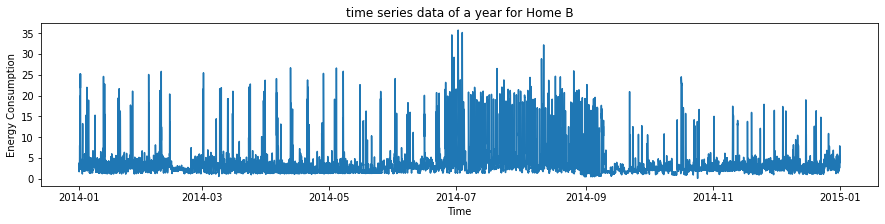

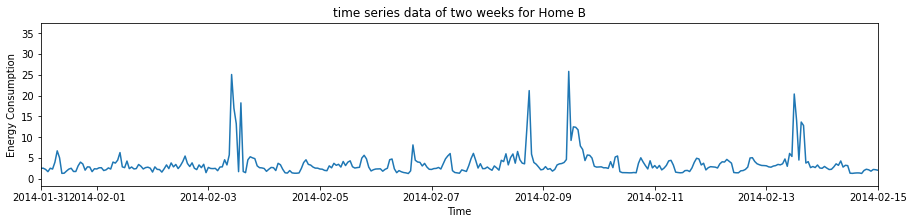

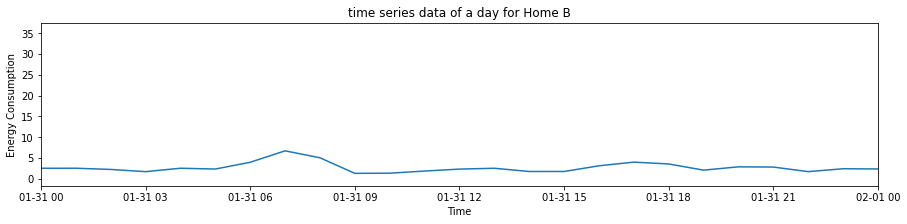

In [18]:
warnings.filterwarnings("ignore")
plot_timeseries(weatherB, 'time series data of a year for Home B')
plot_timeseries_weeks(weatherB, 'time series data of two weeks for Home B')
plot_timeseries_day(weatherB, 'time series data of a day for Home B')

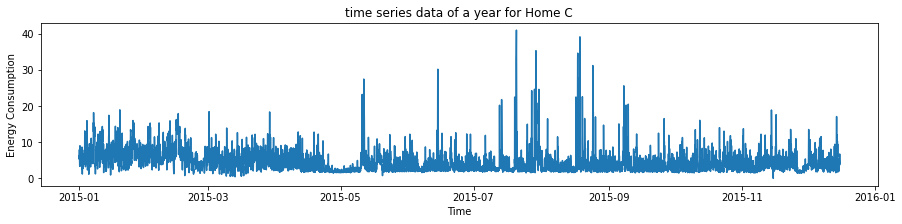

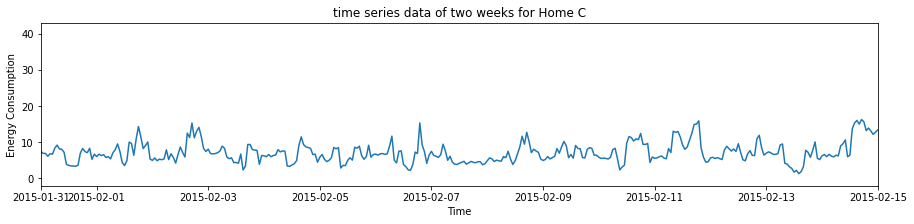

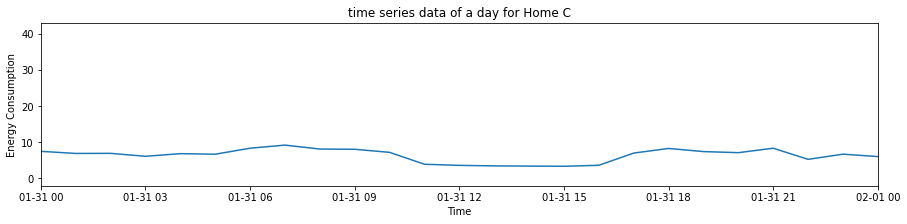

In [19]:
plot_timeseries(weatherC, 'time series data of a year for Home C')
plot_timeseries_weeks(weatherC, 'time series data of two weeks for Home C')
plot_timeseries_day(weatherC, 'time series data of a day for Home C')

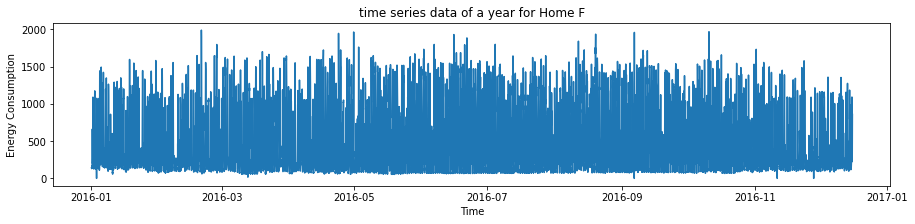

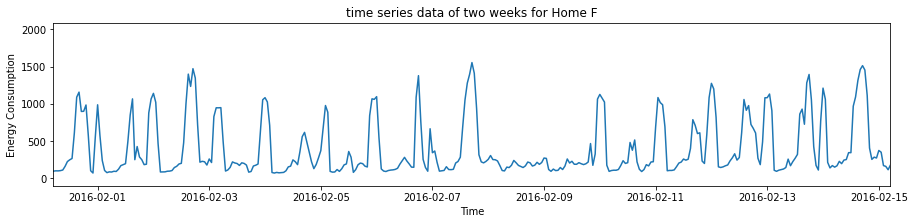

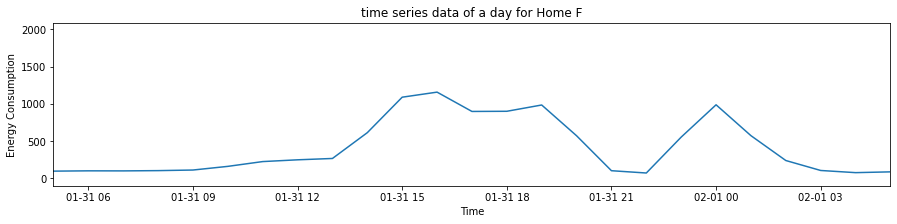

In [20]:
plot_timeseries(weatherF, 'time series data of a year for Home F')
plot_timeseries_weeks(weatherF, 'time series data of two weeks for Home F')
plot_timeseries_day(weatherF, 'time series data of a day for Home F')

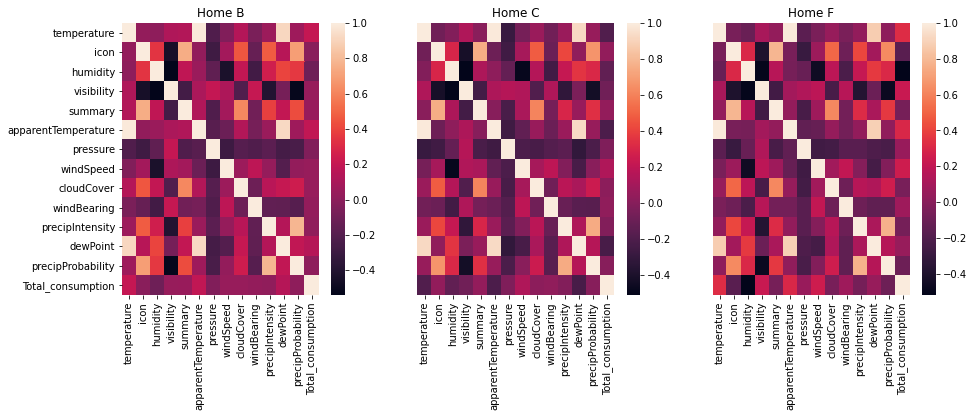

In [21]:
Bcorr = houseB.corr()
Ccorr = houseC.corr()
Fcorr = houseF.corr()

fig, ax = plt.subplots(figsize=(15,5), ncols=3, nrows=1)
ax[0].set_title("Home B")
ax[1].set_title("Home C")
ax[2].set_title("Home F")
sns.heatmap(Bcorr,ax=ax[0])
sns.heatmap(Ccorr,ax=ax[1], yticklabels='')
sns.heatmap(Fcorr,ax=ax[2],yticklabels='')

## **Data Modelling and Prediction Models**

**Model 0: Naive Model(Persistence Algorithm)**

In [0]:
def split_dataset(home):
  train, test = train_test_split(home, test_size = 0.20, shuffle=False)
  #val,test = train_test_split(val_test, test_size = 0.50, random_state = 1)
  print("Spliting Dataset in training = 80% and testing = 20% ratio.")
  return [train,test]

In [0]:
def Calc_MAE(true,pred):
  MAE = np.sum(abs(true - pred))/true.shape[0]
  return MAE

In [0]:
def Naive_Model(home):
    
  New_total = home.Total_consumption
  home["Next_hour"] = New_total.shift(-1)
  home["Next_day"] = New_total.shift(-24)

  home = home.dropna()
  [train,test] = split_dataset(home)
  MAE_hour = Calc_MAE(test["Total_consumption"],test["Next_hour"])
  MAE_day = Calc_MAE(test["Total_consumption"],test["Next_day"])
  print("Mean Absolute Error for Naive Model for next hour=",MAE_hour)
  print("Mean Absolute Error for Naive Model for next Day=",MAE_day)
  return [home,MAE_hour,MAE_day]

In [25]:
laggedB = houseB.copy()
laggedB,MAE_hour,MAE_day = Naive_Model(laggedB)
MAE_NextHour_B.append(MAE_hour)
MAE_NextDay_B.append(MAE_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Naive Model for next hour= 0.948038331438215
Mean Absolute Error for Naive Model for next Day= 1.4336747638306637


In [26]:
laggedC = houseC.copy()
laggedC,MAE_hour,MAE_day = Naive_Model(laggedC)
MAE_NextHour_C.append(MAE_hour)
MAE_NextDay_C.append(MAE_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Naive Model for next hour= 1.2184935316642729
Mean Absolute Error for Naive Model for next Day= 1.8159641086379412


In [27]:
laggedF = houseF.copy()
laggedF,MAE_hour,MAE_day = Naive_Model(laggedF)
MAE_NextHour_F.append(MAE_hour)
MAE_NextDay_F.append(MAE_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Naive Model for next hour= 171.5334679809642
Mean Absolute Error for Naive Model for next Day= 276.514154977129


**Model 1: Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [0]:
def split_dataset_y(home,y):
  train, test, y_train, y_test = train_test_split(home,y, test_size = 0.20, shuffle=False)
  print("Spliting Dataset in training = 80% and testing = 20% ratio.")
  return [train, test, y_train, y_test]

In [0]:
def Min_max_scaling(home):
  scaler = MinMaxScaler()
  scaler.fit(home)
  home = scaler.transform(home)
  return home

In [0]:
def prediction(reg,data,true):
  pred = reg.predict(data)
  return [Calc_MAE(true,pred),pred]


In [0]:
#Plotting Performance
def plot_performance(test, y_test, pred, weather, title=None):

    test = pd.DataFrame(test)
    test['time'] = weather['time']
    plt.figure(figsize=(15,3))
    plt.title(title + ' with 15 days duration')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.plot(test.time, y_test, label='True data')
    plt.plot(test.time, pred, label='Predicted data')
    plt.legend()
    plt.xlim(left=test.time.iloc[0], right=test.time.iloc[24*15])


In [0]:
def linear_reg(home_type, home,weather):
  
  y_next_hour = home["Next_hour"]
  y_next_day = home["Next_day"]
  home = home.drop(["Next_hour"],axis = 1)
  home = home.drop(["Next_day"],axis = 1)
  #home = home.drop(["Total_consumption"],axis = 1)


  #Min_Max Scaling of Data
  home = Min_max_scaling(home)
  
  #For Next Hour
  [train_next_hour, test_next_hour, y_train_next_hour, y_test_next_hour] =  split_dataset_y(home,y_next_hour)
  reg_hour = LinearRegression().fit(train_next_hour,y_train_next_hour)
  MAE_test_hour,pred_hour = prediction(reg_hour,test_next_hour,y_test_next_hour)
  print("Mean Absolute Error for Linear Regression for next hour = ", MAE_test_hour)
  
  #Plotting Performance
  test_next_hour = pd.DataFrame(test_next_hour)
  plot_performance(test_next_hour, y_test_next_hour, pred_hour, weather, home_type + ': True and Predicted Data for Next Hour')

  #For Next Day
  [train_next_day, test_next_day, y_train_next_day, y_test_next_day] =  split_dataset_y(home,y_next_day)
  reg_day = LinearRegression().fit(train_next_day,y_train_next_day)
  MAE_test_day,pred_day = prediction(reg_day,test_next_day,y_test_next_day)
  print("Mean Absolute Error for Linear Regression for next day = ", MAE_test_day)

  #Plotting Performance
  test_next_day = pd.DataFrame(test_next_day)
  plot_performance(test_next_day,y_test_next_day,pred_day,weather,home_type + ':True and Predicted Data for Next Day')

  return [MAE_test_hour,MAE_test_day]

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Linear Regression for next hour =  0.9680266850349996
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Linear Regression for next day =  1.2209428742678372


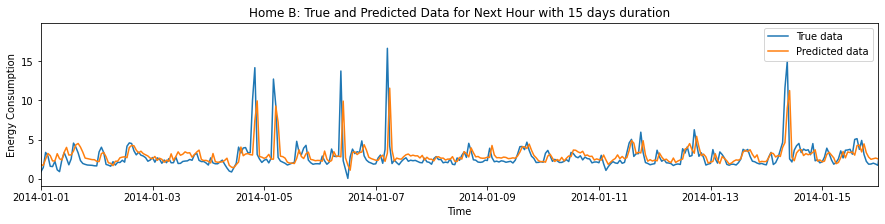

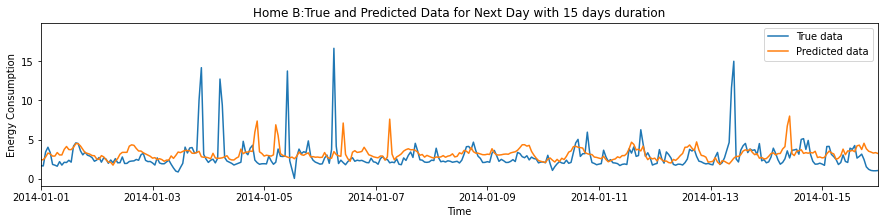

In [34]:
laggedB_LR = laggedB.copy()
[MAE_test_hour,MAE_test_day] =  linear_reg('Home B',laggedB_LR,weatherB)
MAE_NextHour_B.append(MAE_test_hour)
MAE_NextDay_B.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Linear Regression for next hour =  1.159536898139981
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Linear Regression for next day =  1.5823510223243737


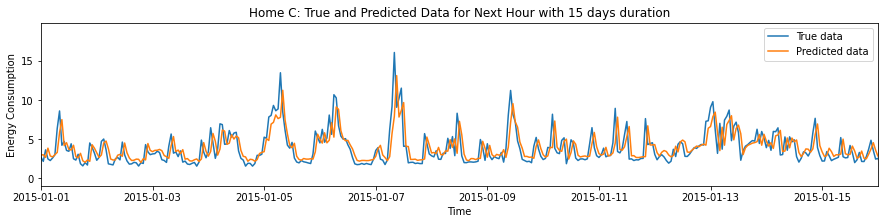

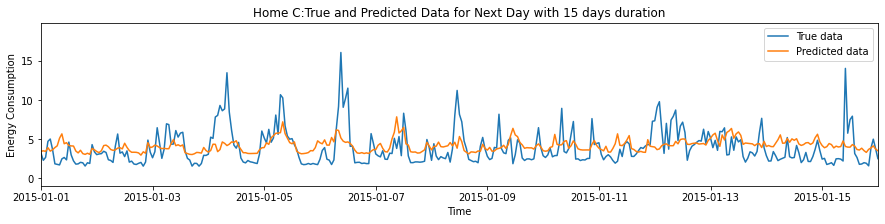

In [35]:
laggedC_LR = laggedC.copy()
[MAE_test_hour,MAE_test_day] =  linear_reg('Home C',laggedC_LR,weatherC)
MAE_NextHour_C.append(MAE_test_hour)
MAE_NextDay_C.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Linear Regression for next hour =  179.386910233394
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Linear Regression for next day =  272.2058246234367


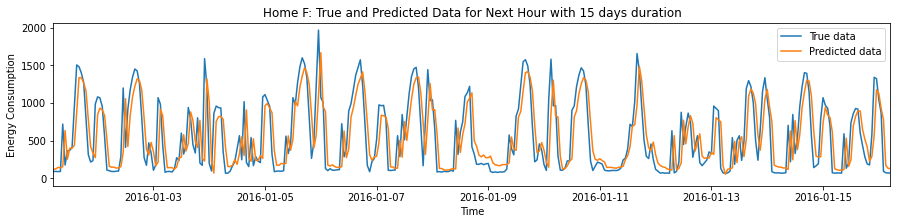

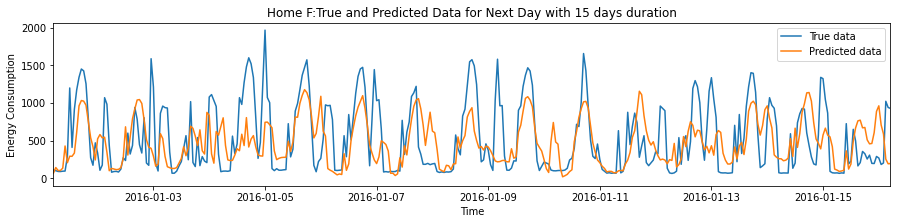

In [36]:
laggedF_LR = laggedF.copy()
[MAE_test_hour,MAE_test_day] =  linear_reg('Home F',laggedF_LR,weatherF)
MAE_NextHour_F.append(MAE_test_hour)
MAE_NextDay_F.append(MAE_test_day)

**Model 2: XGBRegressor**

In [0]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
import warnings

In [0]:
def XGBRegressor_model(home_type, home,weather):

  y_next_hour = home["Next_hour"]
  y_next_day = home["Next_day"]
  home = home.drop(["Next_hour"],axis = 1)
  home = home.drop(["Next_day"],axis = 1)
  #home = home.drop(["Total_consumption"],axis = 1)



  #Min_Max Scaling of Data
  #home = Min_max_scaling(home)
  
  #For Next Hour
  [train_next_hour, test_next_hour, y_train_next_hour, y_test_next_hour] =  split_dataset_y(home,y_next_hour)
  #warnings.filterwarnings("ignore")
  reg_hour = xgb.XGBRegressor(n_estimators=1000).fit(train_next_hour,y_train_next_hour)
  MAE_test_hour, pred_hour = prediction(reg_hour,test_next_hour,y_test_next_hour)
  print("Mean Absolute Error for XGBRegressor model for next hour = ", MAE_test_hour)
  
  #Plotting Performance
  plot_performance(test_next_hour,y_test_next_hour,pred_hour,weather,home_type + ': True and Predicted Data for Next Hour')


  #For Next Day
  [train_next_day, test_next_day, y_train_next_day, y_test_next_day] =  split_dataset_y(home,y_next_day)
  reg_day = xgb.XGBRegressor(n_estimators=1000).fit(train_next_day,y_train_next_day)
  MAE_test_day, pred_day = prediction(reg_day,test_next_day,y_test_next_day)
  print("Mean Absolute Error for XGBRegressor model for next day = ", MAE_test_day)

  #Plotting Performance
  plot_performance(test_next_day,y_test_next_day,pred_day,weather,home_type + ':True and Predicted Data for Next Day')
  return [reg_hour,reg_day,MAE_test_hour,MAE_test_day]

Spliting Dataset in training = 80% and testing = 20% ratio.
[17:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error for XGBRegressor model for next hour =  1.0377991803121285
Spliting Dataset in training = 80% and testing = 20% ratio.
[17:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error for XGBRegressor model for next day =  1.292533680609301


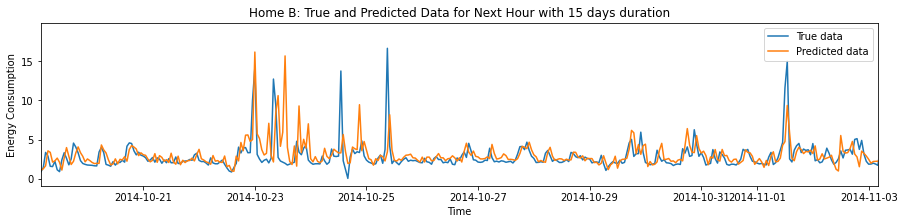

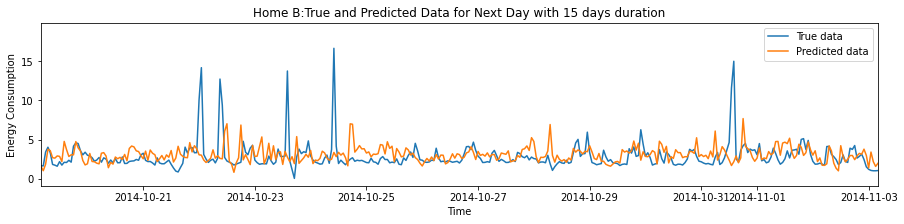

In [39]:
laggedB_XGB = laggedB.copy()
[reg_hour_B,reg_day_B,MAE_test_hour,MAE_test_day] = XGBRegressor_model('Home B',laggedB_XGB,weatherB)
MAE_NextHour_B.append(MAE_test_hour)
MAE_NextDay_B.append(MAE_test_day)

Home B: Feature importance for next hour


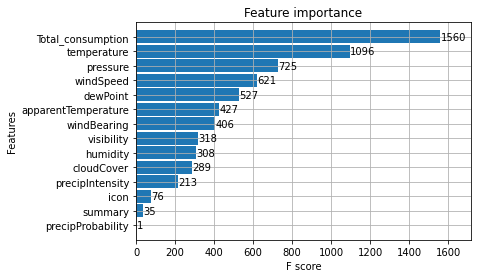

In [40]:
print("Home B: Feature importance for next hour")
_ = plot_importance(reg_hour_B, height=0.9)

Home B: Feature importance for next day


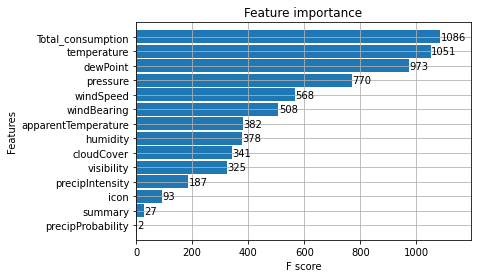

In [41]:
print("Home B: Feature importance for next day")
_ = plot_importance(reg_day_B, height=0.9)

Spliting Dataset in training = 80% and testing = 20% ratio.
[17:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error for XGBRegressor model for next hour =  1.2354159840134615
Spliting Dataset in training = 80% and testing = 20% ratio.
[17:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error for XGBRegressor model for next day =  1.7857297867371613


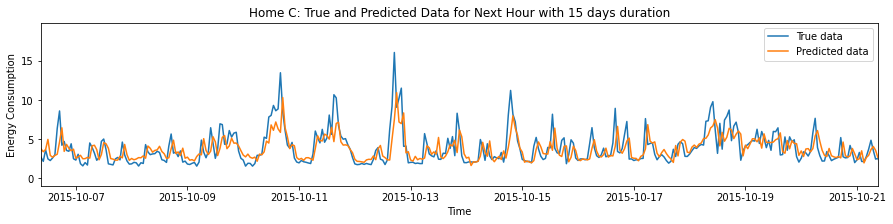

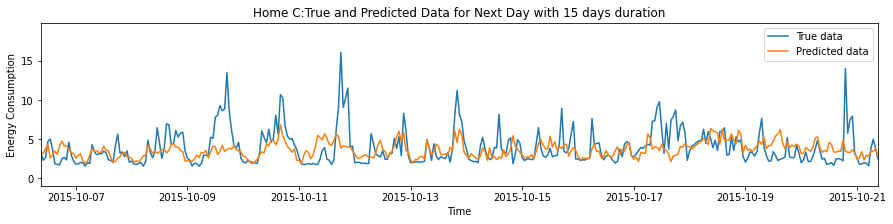

In [42]:
laggedC_XGB = laggedC.copy()
[reg_hour_C,reg_day_C,MAE_test_hour,MAE_test_day] = XGBRegressor_model('Home C',laggedC_XGB,weatherC)
MAE_NextHour_C.append(MAE_test_hour)
MAE_NextDay_C.append(MAE_test_day)

Home C: Feature importance for next hour


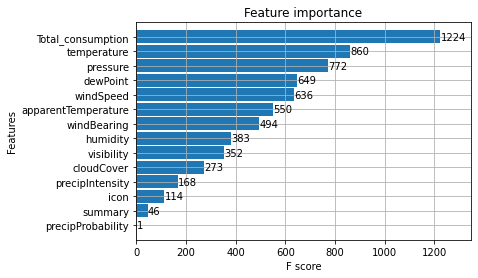

In [43]:
print("Home C: Feature importance for next hour")
_ = plot_importance(reg_hour_C, height=0.9)

Home C: Feature importance for next day


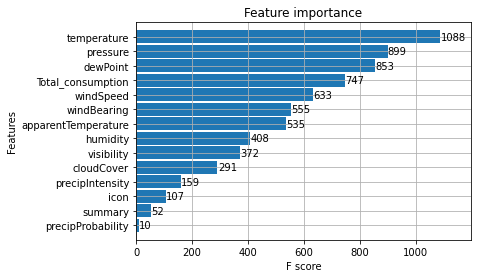

In [44]:
print("Home C: Feature importance for next day")
_ = plot_importance(reg_day_C, height=0.9)

Spliting Dataset in training = 80% and testing = 20% ratio.
[17:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error for XGBRegressor model for next hour =  184.17309238010958
Spliting Dataset in training = 80% and testing = 20% ratio.
[17:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error for XGBRegressor model for next day =  270.7124707930342


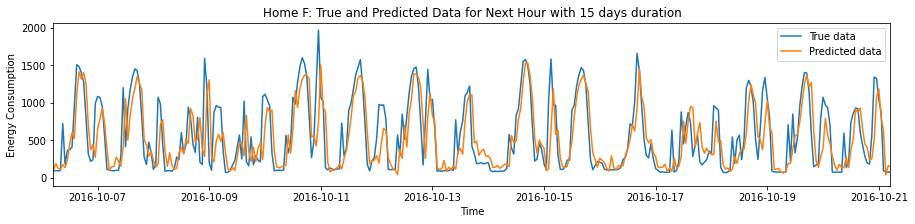

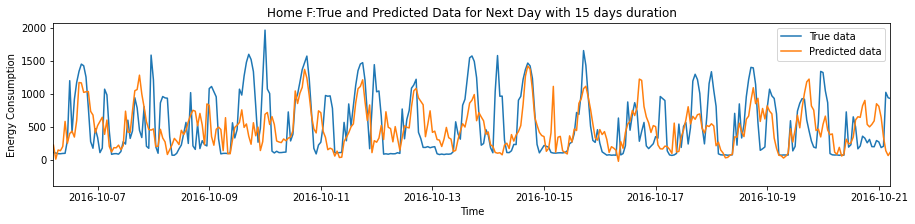

In [45]:
laggedF_XGB = laggedF.copy()
[reg_hour_F,reg_day_F,MAE_test_hour,MAE_test_day] = XGBRegressor_model('Home F',laggedF_XGB,weatherF)
MAE_NextHour_F.append(MAE_test_hour)
MAE_NextDay_F.append(MAE_test_day)

Home F: Feature importance for next hour


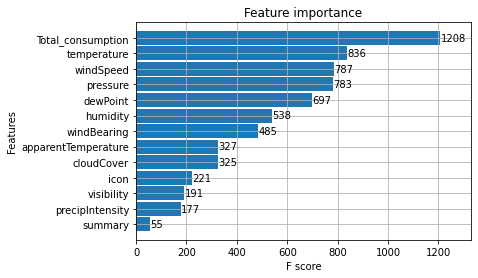

In [46]:
print("Home F: Feature importance for next hour")
_ = plot_importance(reg_hour_F, height=0.9)

Home F: Feature importance for next day


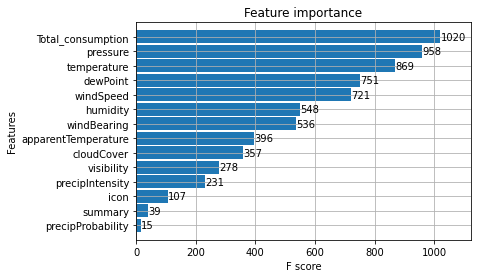

In [47]:
print("Home F: Feature importance for next day")
_ = plot_importance(reg_day_F, height=0.9)

**Model 3: AdaBoostRegressor**

In [0]:
def AdaBoostRegressor_model(home_type, home,weather):

  y_next_hour = home["Next_hour"]
  y_next_day = home["Next_day"]
  home = home.drop(["Next_hour"],axis = 1)
  home = home.drop(["Next_day"],axis = 1)
  #home = home.drop(["Total_consumption"],axis = 1)


  #Min_Max Scaling of Data
  home = Min_max_scaling(home)

  warnings.filterwarnings("ignore")
  #For Next Hour
  [train_next_hour, test_next_hour, y_train_next_hour, y_test_next_hour] =  split_dataset_y(home,y_next_hour)
  #warnings.filterwarnings("ignore")
  reg_hour = AdaBoostRegressor().fit(train_next_hour,y_train_next_hour)
  MAE_test_hour, pred_hour = prediction(reg_hour,test_next_hour,y_test_next_hour)
  print("Mean Absolute Error for AdaBoostRegressor_model for next hour = ", MAE_test_hour)
  
  #Plotting Performance
  plot_performance(test_next_hour,y_test_next_hour,pred_hour,weather,home_type + ': True and Predicted Data for Next Hour')


  #For Next Day
  [train_next_day, test_next_day, y_train_next_day, y_test_next_day] =  split_dataset_y(home,y_next_day)
  reg_day = AdaBoostRegressor().fit(train_next_day,y_train_next_day)
  MAE_test_day, pred_day = prediction(reg_day,test_next_day,y_test_next_day)
  print("Mean Absolute Error for AdaBoostRegressor_model for next day = ", MAE_test_day)

  #Plotting Performance
  plot_performance(test_next_day,y_test_next_day,pred_day,weather,home_type + ':True and Predicted Data for Next Day')
  return [reg_hour,reg_day,MAE_test_hour,MAE_test_day]

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next hour =  6.004708723239759
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next day =  8.227734442949965


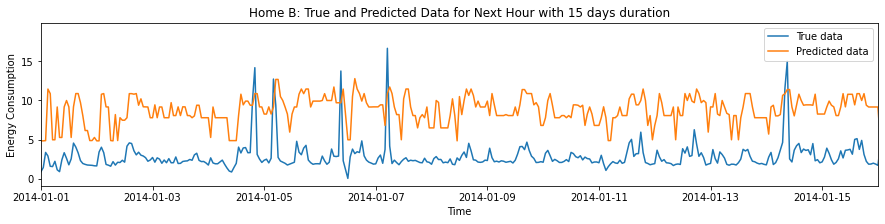

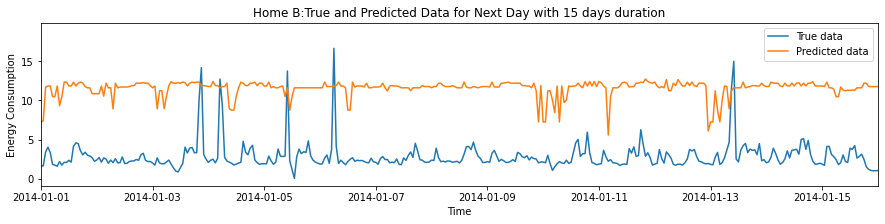

In [49]:
laggedB_AdaB = laggedB.copy()
[reg_hour_B,reg_day_B,MAE_test_hour,MAE_test_day] = AdaBoostRegressor_model('Home B',laggedB_AdaB,weatherB)
MAE_NextHour_B.append(MAE_test_hour)
MAE_NextDay_B.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next hour =  2.1061336228248955
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next day =  1.8610133550636703


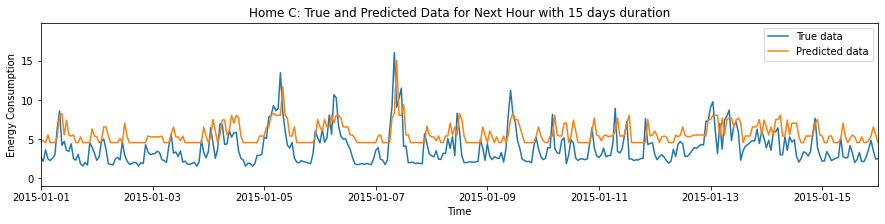

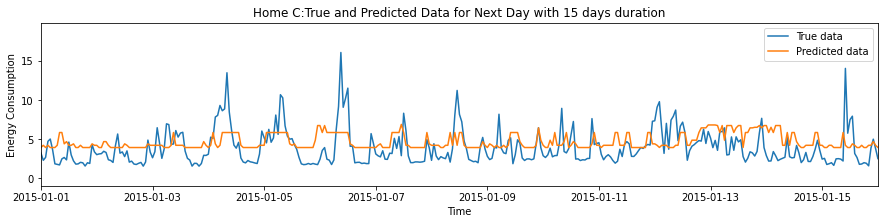

In [50]:
laggedC_AdaB = laggedC.copy()
[reg_hour_C,reg_day_C,MAE_test_hour,MAE_test_day] = AdaBoostRegressor_model('Home C',laggedC_AdaB,weatherC)
MAE_NextHour_C.append(MAE_test_hour)
MAE_NextDay_C.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next hour =  263.33298067731545
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next day =  351.5085353337775


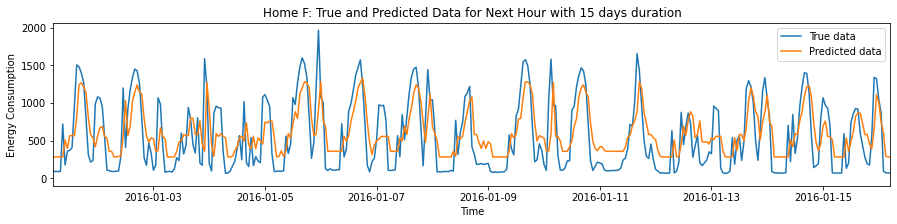

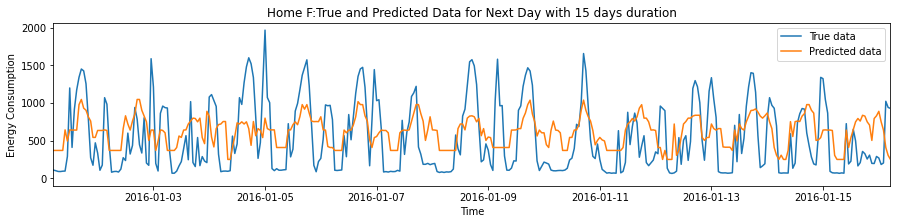

In [51]:
laggedF_AdaB = laggedF.copy()
[reg_hour_F,reg_day_F,MAE_test_hour,MAE_test_day] = AdaBoostRegressor_model('Home F',laggedF_AdaB,weatherF)
MAE_NextHour_F.append(MAE_test_hour)
MAE_NextDay_F.append(MAE_test_day)

**Model 4: Bagging Regressor**

In [0]:
def BaggingRegressor_model(home_type, home,weather):

  y_next_hour = home["Next_hour"]
  y_next_day = home["Next_day"]
  home = home.drop(["Next_hour"],axis = 1)
  home = home.drop(["Next_day"],axis = 1)
  #home = home.drop(["Total_consumption"],axis = 1)


  #Min_Max Scaling of Data
  home = Min_max_scaling(home)

  warnings.filterwarnings("ignore")
  #For Next Hour
  [train_next_hour, test_next_hour, y_train_next_hour, y_test_next_hour] =  split_dataset_y(home,y_next_hour)
  #warnings.filterwarnings("ignore")
  reg_hour = BaggingRegressor().fit(train_next_hour,y_train_next_hour)
  MAE_test_hour, pred_hour = prediction(reg_hour,test_next_hour,y_test_next_hour)
  print("Mean Absolute Error for Bagging Regressor model for next hour = ", MAE_test_hour)
  
  #Plotting Performance
  plot_performance(test_next_hour,y_test_next_hour,pred_hour,weather,home_type + ': True and Predicted Data for Next Hour')


  #For Next Day
  [train_next_day, test_next_day, y_train_next_day, y_test_next_day] =  split_dataset_y(home,y_next_day)
  reg_day = BaggingRegressor().fit(train_next_day,y_train_next_day)
  MAE_test_day, pred_day = prediction(reg_day,test_next_day,y_test_next_day)
  print("Mean Absolute Error for Bagging Regressor model for next day = ", MAE_test_day)

  #Plotting Performance
  plot_performance(test_next_day,y_test_next_day,pred_day,weather,home_type + ':True and Predicted Data for Next Day')
  return [reg_hour,reg_day,MAE_test_hour,MAE_test_day]

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Bagging Regressor model for next hour =  1.1084761651830788
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Bagging Regressor model for next day =  1.3797331290288024


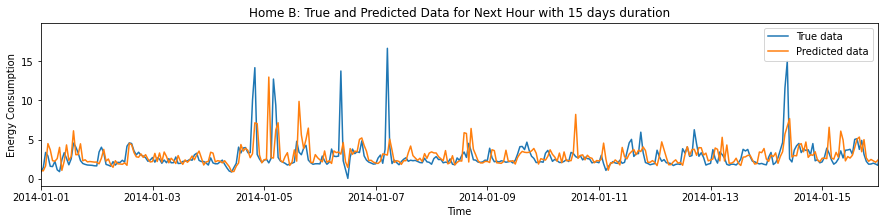

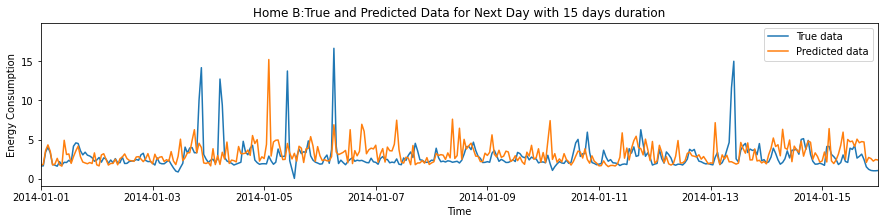

In [53]:
laggedB_BagR = laggedB.copy()
[reg_hour_B,reg_day_B,MAE_test_hour,MAE_test_day] = BaggingRegressor_model('Home B',laggedB_BagR,weatherB)
MAE_NextHour_B.append(MAE_test_hour)
MAE_NextDay_B.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next hour =  1.7334552920433184
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next day =  1.9298943287992731


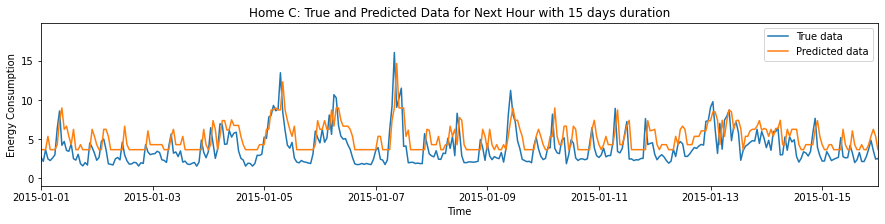

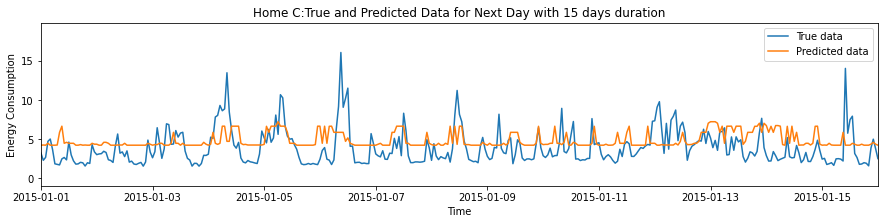

In [54]:
laggedC_BagR = laggedC.copy()
[reg_hour_C,reg_day_C,MAE_test_hour,MAE_test_day] = AdaBoostRegressor_model('Home C',laggedC_BagR,weatherC)
MAE_NextHour_C.append(MAE_test_hour)
MAE_NextDay_C.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next hour =  241.69897394956865
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for AdaBoostRegressor_model for next day =  350.904279962195


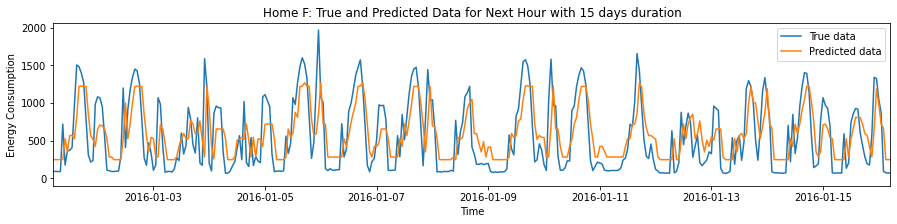

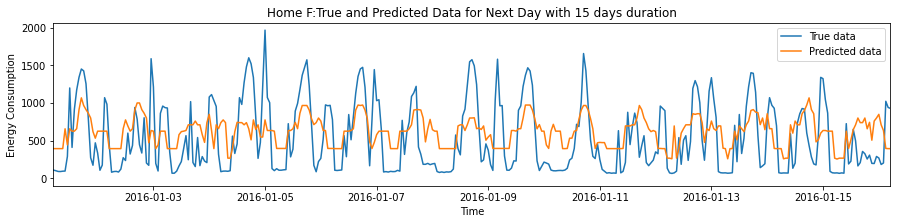

In [55]:
laggedF_BagR = laggedF.copy()
[reg_hour_F,reg_day_F,MAE_test_hour,MAE_test_day] = AdaBoostRegressor_model('Home F',laggedF_BagR,weatherF)
MAE_NextHour_F.append(MAE_test_hour)
MAE_NextDay_F.append(MAE_test_day)

**Model 5: Extra Trees Regressor**

In [0]:
def ExtraTreesRegressor_model(home_type, home,weather):

  y_next_hour = home["Next_hour"]
  y_next_day = home["Next_day"]
  home = home.drop(["Next_hour"],axis = 1)
  home = home.drop(["Next_day"],axis = 1)
  #home = home.drop(["Total_consumption"],axis = 1)


  #Min_Max Scaling of Data
  home = Min_max_scaling(home)

  warnings.filterwarnings("ignore")
  #For Next Hour
  [train_next_hour, test_next_hour, y_train_next_hour, y_test_next_hour] =  split_dataset_y(home,y_next_hour)
  #warnings.filterwarnings("ignore")
  reg_hour = ExtraTreesRegressor().fit(train_next_hour,y_train_next_hour)
  MAE_test_hour, pred_hour = prediction(reg_hour,test_next_hour,y_test_next_hour)
  print("Mean Absolute Error for Extra Trees Regressor model for next hour = ", MAE_test_hour)
  
  #Plotting Performance
  plot_performance(test_next_hour,y_test_next_hour,pred_hour,weather,home_type + ': True and Predicted Data for Next Hour')


  #For Next Day
  [train_next_day, test_next_day, y_train_next_day, y_test_next_day] =  split_dataset_y(home,y_next_day)
  reg_day = ExtraTreesRegressor().fit(train_next_day,y_train_next_day)
  MAE_test_day, pred_day = prediction(reg_day,test_next_day,y_test_next_day)
  print("Mean Absolute Error for Extra Trees Regressor model for next day = ", MAE_test_day)

  #Plotting Performance
  plot_performance(test_next_day,y_test_next_day,pred_day,weather,home_type + ':True and Predicted Data for Next Day')
  return [reg_hour,reg_day,MAE_test_hour,MAE_test_day]

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Extra Trees Regressor model for next hour =  1.1381873264109983
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Extra Trees Regressor model for next day =  1.3290531653027229


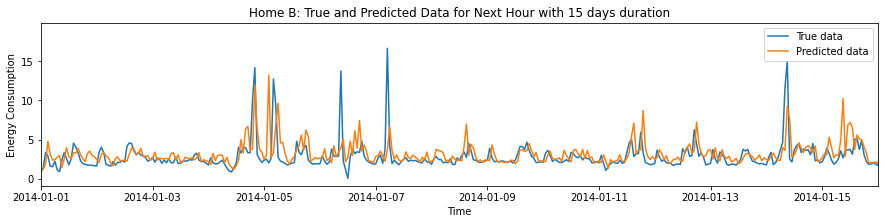

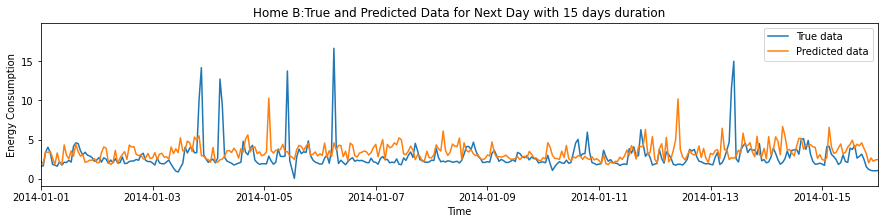

In [57]:
laggedB_ETR = laggedB.copy()
[reg_hour_B,reg_day_B,MAE_test_hour,MAE_test_day] = ExtraTreesRegressor_model('Home B',laggedB_ETR,weatherB)
MAE_NextHour_B.append(MAE_test_hour)
MAE_NextDay_B.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Extra Trees Regressor model for next hour =  1.2385158427732286
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Extra Trees Regressor model for next day =  1.6181261410398473


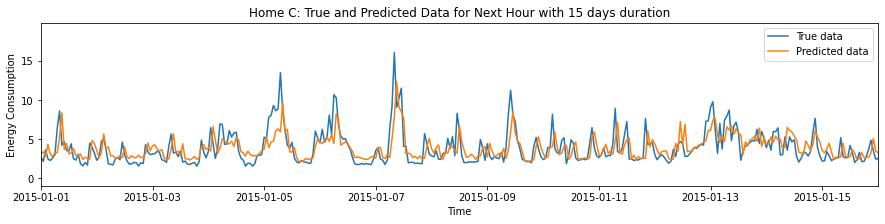

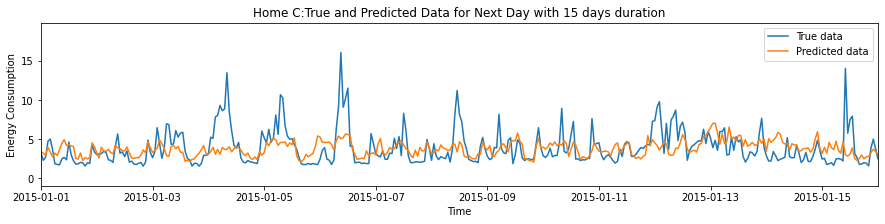

In [58]:
laggedC_ETR = laggedC.copy()
[reg_hour_C,reg_day_C,MAE_test_hour,MAE_test_day] = ExtraTreesRegressor_model('Home C',laggedC_ETR,weatherC)
MAE_NextHour_C.append(MAE_test_hour)
MAE_NextDay_C.append(MAE_test_day)

Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Extra Trees Regressor model for next hour =  184.78683159735294
Spliting Dataset in training = 80% and testing = 20% ratio.
Mean Absolute Error for Extra Trees Regressor model for next day =  271.8044110118289


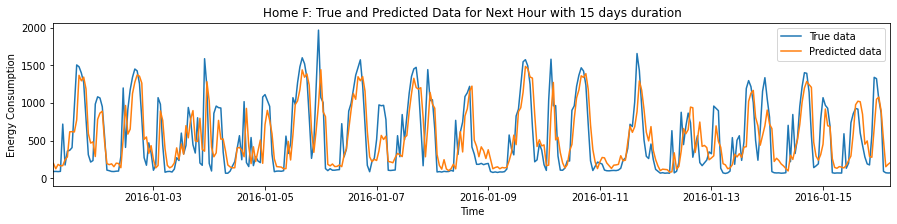

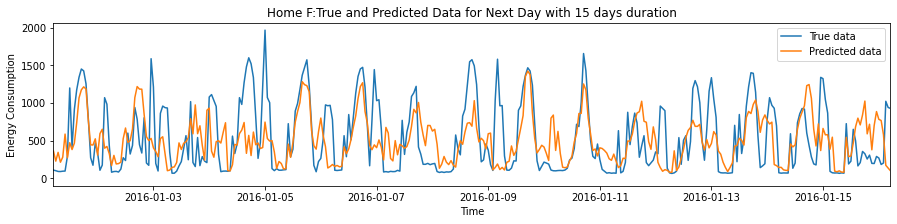

In [59]:
laggedF_ETR = laggedF.copy()
[reg_hour_F,reg_day_F,MAE_test_hour,MAE_test_day] = ExtraTreesRegressor_model('Home F',laggedF_ETR,weatherF)
MAE_NextHour_F.append(MAE_test_hour)
MAE_NextDay_F.append(MAE_test_day)

## **Comparison of Models on the basis of MAE:**

In [0]:
Models = [ "Naive", "LinearReg",  "XGBReg", "AdaBReg",  "BagReg", "ExtraTreesReg"]

For Home B, Best Model for MAE of Next Hour: Naive Model
For Home B, Best Model for MAE of Next Day: LinearReg Model


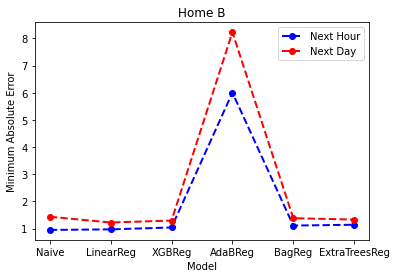

In [61]:
plt.plot( Models,MAE_NextHour_B, marker='o', color='blue', linewidth=2, linestyle='dashed', label="Next Hour")
plt.plot( Models,MAE_NextDay_B, marker='o', color='red', linewidth=2, linestyle='dashed', label="Next Day")
plt.xlabel("Model")
plt.ylabel("Minimum Absolute Error")
plt.title("Home B")
plt.legend()
print("For Home B, Best Model for MAE of Next Hour:", Models[MAE_NextHour_B.index(min(MAE_NextHour_B))],"Model")
print("For Home B, Best Model for MAE of Next Day:", Models[MAE_NextDay_B.index(min(MAE_NextDay_B))],"Model")

For Home C, Best Model for MAE of Next Hour: LinearReg Model
For Home C, Best Model for MAE of Next Day: LinearReg Model


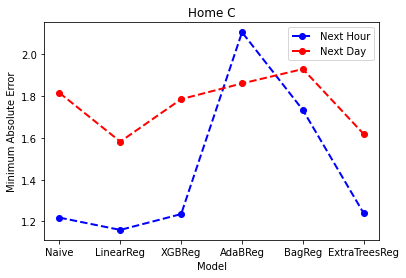

In [62]:
plt.plot( Models,MAE_NextHour_C, marker='o', color='blue', linewidth=2, linestyle='dashed', label="Next Hour")
plt.plot( Models,MAE_NextDay_C, marker='o', color='red', linewidth=2, linestyle='dashed', label="Next Day")
plt.xlabel("Model")
plt.ylabel("Minimum Absolute Error")
plt.title("Home C")
plt.legend()
print("For Home C, Best Model for MAE of Next Hour:", Models[MAE_NextHour_C.index(min(MAE_NextHour_C))],"Model")
print("For Home C, Best Model for MAE of Next Day:", Models[MAE_NextDay_C.index(min(MAE_NextDay_C))],"Model")

For Home F, Best Model for MAE of Next Hour: Naive Model
For Home F, Best Model for MAE of Next Day: XGBReg Model


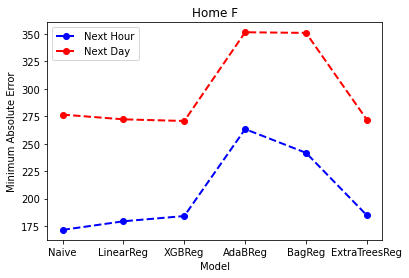

In [63]:
plt.plot( Models,MAE_NextHour_F, marker='o', color='blue', linewidth=2, linestyle='dashed', label="Next Hour")
plt.plot( Models,MAE_NextDay_F, marker='o', color='red', linewidth=2, linestyle='dashed', label="Next Day")
plt.xlabel("Model")
plt.ylabel("Minimum Absolute Error")
plt.title("Home F")
plt.legend()
print("For Home F, Best Model for MAE of Next Hour:", Models[MAE_NextHour_F.index(min(MAE_NextHour_F))],"Model")
print("For Home F, Best Model for MAE of Next Day:", Models[MAE_NextDay_F.index(min(MAE_NextDay_F))],"Model")